In [240]:
from keras.preprocessing import sequence  
from keras.models import Sequential  
from keras.layers import Dense, Dropout  
from keras import regularizers 
from keras.models import load_model
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.preprocessing import MinMaxScaler  
import pandas as pd
import time  
import datetime 
import math
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import r2_score
%run function.py

In [279]:
test_data = pd.read_csv("paper_pricing_by_bsm_test.csv")

vol = '60days_HV'
bs_pricing = 'bs_HV60'

for i in test_data.index:
    if test_data.loc[i, bs_pricing]< 0:
        test_data.loc[i, bs_pricing] = 0

# Separate data by Moneyness Ratio
VDOTM = test_data[test_data['moneyness_ratio'] < 0.85]
DOTM = test_data[(test_data['moneyness_ratio'] >= 0.85) & (test_data['moneyness_ratio'] < 0.9)]
OTM = test_data[(test_data['moneyness_ratio'] >= 0.9) & (test_data['moneyness_ratio'] < 0.95)]
JOTM = test_data[(test_data['moneyness_ratio'] >= 0.95) & (test_data['moneyness_ratio'] < 0.99)]
ATM = test_data[(test_data['moneyness_ratio'] >= 0.99) & (test_data['moneyness_ratio'] < 1.01)]
JITM = test_data[(test_data['moneyness_ratio'] >= 1.01) & (test_data['moneyness_ratio'] < 1.05)]
ITM = test_data[(test_data['moneyness_ratio'] >= 1.05) & (test_data['moneyness_ratio'] < 1.1)]
DITM = test_data[(test_data['moneyness_ratio'] >= 1.1) & (test_data['moneyness_ratio'] < 1.35)]
VDITM = test_data[test_data['moneyness_ratio'] >= 1.35]

#VDOTM = a[a['moneyness_ratio'] < 0.85]
#DOTM = a[(a['moneyness_ratio'] >= 0.85) & (a['moneyness_ratio'] < 0.9)]
#OTM = a[(a['moneyness_ratio'] >= 0.9) & (a['moneyness_ratio'] < 0.95)]
#JOTM = a[(a['moneyness_ratio'] >= 0.95) & (a['moneyness_ratio'] < 0.99)]
#ATM = a[(a['moneyness_ratio'] >= 0.99) & (a['moneyness_ratio'] < 1.01)]
#JITM = a[(a['moneyness_ratio'] >= 1.01) & (a['moneyness_ratio'] < 1.05)]
#ITM = a[(a['moneyness_ratio'] >= 1.05) & (a['moneyness_ratio'] < 1.1)]
#DITM = a[(a['moneyness_ratio'] >= 1.1) & (a['moneyness_ratio'] < 1.35)]
#VDITM = a[a['moneyness_ratio'] >= 1.35]

# Separate data by Time to Maturity
short_term = test_data[test_data['T'] < 60]
medium_term = test_data[(test_data['T'] >= 60) & (test_data['T'] < 180)]
long_term = test_data[test_data['T'] >= 180]
extreme_term = test_data[test_data['T'] < 6]

# Separate by performance quantile
ae_bs = abs(test_data['close'] - test_data[bs_pricing])
b = ae_bs.sort_values(ascending = False)
BS_1st_quantile = test_data.loc[abs(test_data['close'] - test_data[bs_pricing]) <= b.quantile(0.25)]
BS_2nd_quantile = test_data.loc[(abs(test_data['close'] - test_data[bs_pricing]) > b.quantile(0.25)) & (abs(test_data['close'] - test_data[bs_pricing]) <= b.quantile(0.5))]
BS_3rd_quantile = test_data.loc[(abs(test_data['close'] - test_data[bs_pricing]) > b.quantile(0.5)) & (abs(test_data['close'] - test_data[bs_pricing]) <= b.quantile(0.75))]
BS_4th_quantile = test_data.loc[abs(test_data['close'] - test_data[bs_pricing]) > b.quantile(0.75)]

# Separate by esitimation precision
bs_mae = metrics.mean_absolute_error(test_data['close'], test_data[bs_pricing])
BS_under_average_precision = test_data.loc[abs(test_data['close'] - test_data[bs_pricing]) > bs_mae]
BS_above_average_precision = test_data.loc[abs(test_data['close'] - test_data[bs_pricing]) <= bs_mae]

In [292]:
#a = extreme_term
#b = test_data[test_data['moneyness_ratio'] >= 1.35]

test_data_select = BS_under_average_precision
test_data_select.shape

(13287, 36)

In [293]:
x_test_pd = test_data_select.loc[:, ['T', 'r', 'exercise_price', 'underlying_close', vol, bs_pricing]]
y_test_pd = test_data_select.loc[:, ['close']]

min_max_scaler = MinMaxScaler()

min_max_scaler.fit(x_test_pd)
x_test = min_max_scaler.transform(x_test_pd)

min_max_scaler.fit(y_test_pd)
y_test = min_max_scaler.transform(y_test_pd)

prediction = DataFrame()

for i in range(1, 5):
    model_name = "paper_HNN_60HV_%s.h5" %i
    model = load_model(model_name)
    
    y_predict = model.predict(x_test)
    
    a = []
    
    for t in range(0, len(y_predict)):
        a.append(float(y_predict[t]))
    
    colum_name = "model_num %s" %i
    prediction[colum_name] = a

In [294]:
prediction.head()

,model_num 1,model_num 2,model_num 3,model_num 4
0,0.009286,0.012560,0.014796,0.012796
1,0.467312,0.454701,0.469917,0.456031
2,0.491142,0.496087,0.497934,0.500611
3,0.612605,0.609857,0.639878,0.637047
4,0.061534,0.060314,0.056639,0.056865


In [295]:
model_number = 'model_num 1'


MSE = metrics.mean_squared_error(y_test, prediction[model_number])
MAE = metrics.mean_absolute_error(y_test, prediction[model_number])
r2 = r2_score(y_test, prediction[model_number])

print(MSE)
print(MAE)
print(r2)

#prediction_visualization(y_test, prediction[model_number], 30, 500)

0.001608624361855543
0.03218051338885954
0.8940625022413842


0.001700984102994809
0.0334004786084205
0.8879800630455479


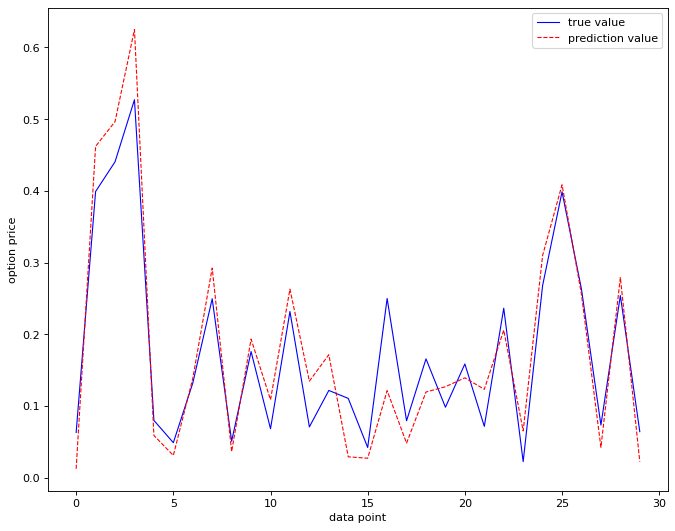

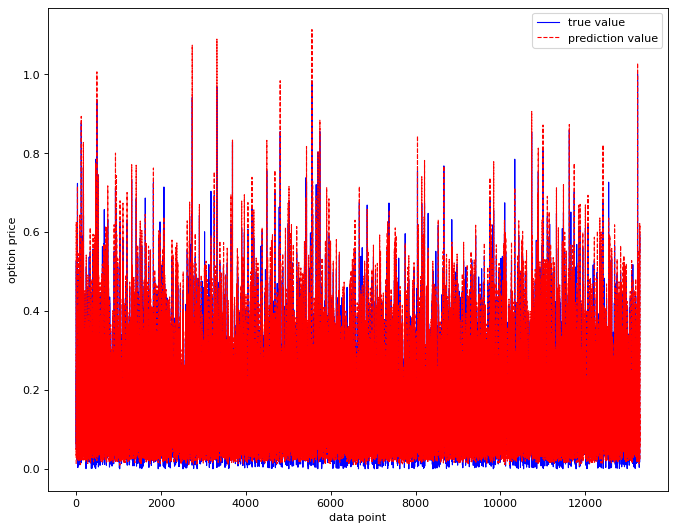

In [296]:
# Take model average as output
y_new = prediction.mean(axis = 1)
y_new = y_new.values
y_new = y_new.reshape(len(y_test), 1)

MSE_new = metrics.mean_squared_error(y_test, y_new)
MAE_new = metrics.mean_absolute_error(y_test, y_new)
r2_new = r2_score(y_test, y_new)

print(MSE_new)
print(MAE_new)
print(r2_new)

prediction_visualization(y_test, y_new, 30, 0)
prediction_visualization(y_test, y_new, len(y_test), 0)

0.005160559945836737
0.058176953640146835
0.8879800630455479


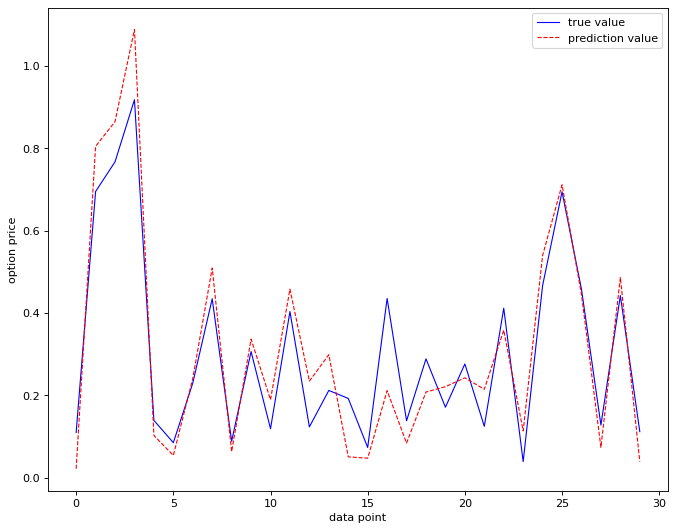

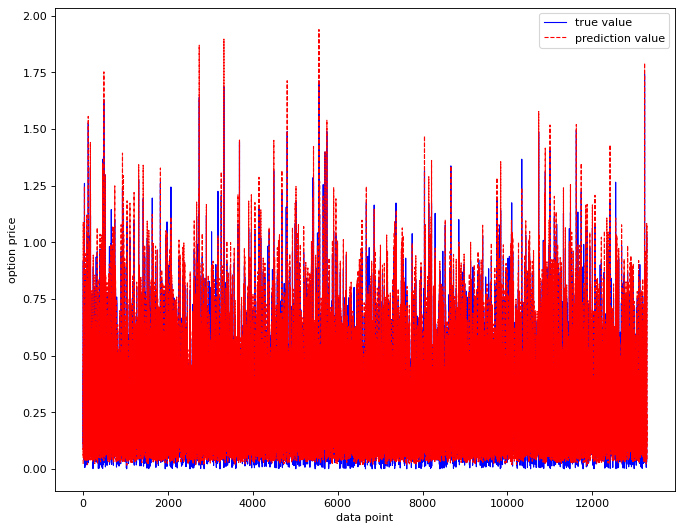

In [297]:
# Output after renormalization
min_max_scaler.fit(y_test_pd)
y_new1 = min_max_scaler.inverse_transform(y_new) 

MSE1 = metrics.mean_squared_error(y_test_pd, y_new1)
MAE1 = metrics.mean_absolute_error(y_test_pd, y_new1)
r2_1 = r2_score(y_test_pd, y_new1)

print(MSE1)
print(MAE1)
print(r2_1)

prediction_visualization(y_test_pd, y_new1, 30, 0)
prediction_visualization(y_test_pd, y_new1, len(y_test_pd), 0)